# Ocean macronutrients

---

## Overview
The availability of several macronutrients controls production in most of the ocean: nitrate, phosphate, and silicate. Here we take a look at maps and depth profiles of these nutrients, and compare them to an observational dataset.

1. General setup
2. Subsetting
3. Transforming from monthly to annual data
4. Compare to World Ocean Atlas data
5. Make depth profiles

TO DO: Adjust parallel setup to fix warnings, clean up comments

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |


- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
# files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
# ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, decode_times=True)
# ds
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset> Size: 182GB
Dimensions:                         (nlat: 384, nlon: 320, time: 768, z_t: 60,
                                     z_w: 60, lat_aux_grid: 395, moc_z: 61,
                                     d2: 2, z_t_150m: 15, z_w_bot: 60,
                                     z_w_top: 60)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                    (lat_aux_grid) float32 2kB -79.49 ... 90.0
  * moc_z                           (moc_z) float32 244B 0.0 1e+03 ... 5.5e+05
  * time                            (time) object 6kB 1958-02-01 00:00:00 ......
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                             (z_w) float32 240B 0.0 1e+03 ... 5.25e+05
  * z_w_bot                         (z_w_bot) float32 240B 1e+03 ... 5.5e+05
  * z_w_top                         (z_w_top) float32 240B 0.0 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/96)
    ANGLE                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                          (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 08:37:09 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting
Make our dataset smaller so it has just a couple of macronutrient variables we're interested in.

In [7]:
variables =['PO4','NO3','SiO3']

In [8]:
keep_vars=['z_t','z_t_150m','dz','time_bound','time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

Let's take a quick look at nitrate to make sure that things look okay...

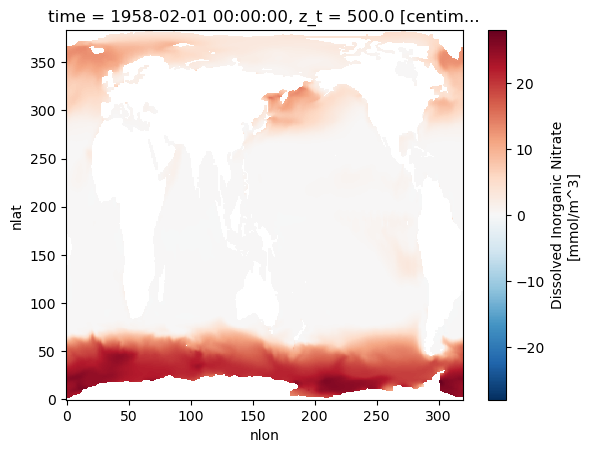

In [9]:
ds.NO3.isel(time=0,z_t=0).plot()

## Transforming from monthly to annual data
We can't just use xarray's regular `mean()` function because months have different numbers of days in them, so we have to weight by that to ensure the annual mean is accurate. See this [ESDS blog post](https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/) for a more detailed explanation with examples!

In [10]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")

In [11]:
ds_annual = year_mean(ds)
ds_annual

<xarray.Dataset> Size: 12GB
Dimensions:   (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15, year: 65)
Coordinates:
    TLAT      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG     (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t       (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m  (z_t_150m) float32 60B 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * year      (year) int64 520B 1958 1959 1960 1961 1962 ... 2019 2020 2021 2022
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA     (year, nlat, nlon) float64 64MB dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz        (year, z_t) float64 31kB dask.array<chunksize=(1, 60), meta=np.ndarray>
    NO3       (year, z_t, nlat, nlon) float64 4GB dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    PO4       (year, z_t, nlat, nlon) float64 4GB dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    SiO3      (year, z_t, nlat, nlon) float64 4GB dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>

Note that our time coordinate is now called `year` instead, and has only years now. We can select specific years to plot:

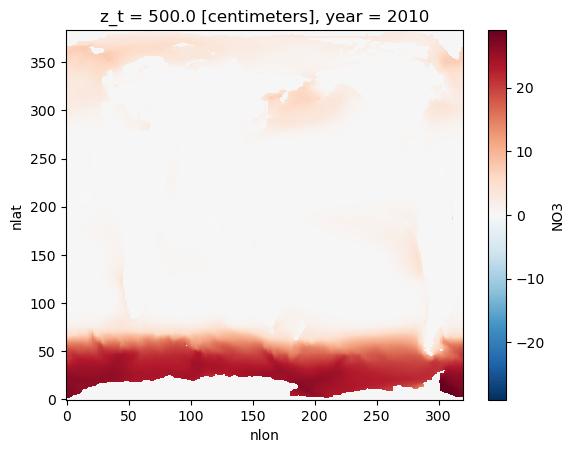

In [12]:
ds_annual['NO3'].sel(year=2010).isel(z_t=0).plot()

### Let's make a nicer-looking map

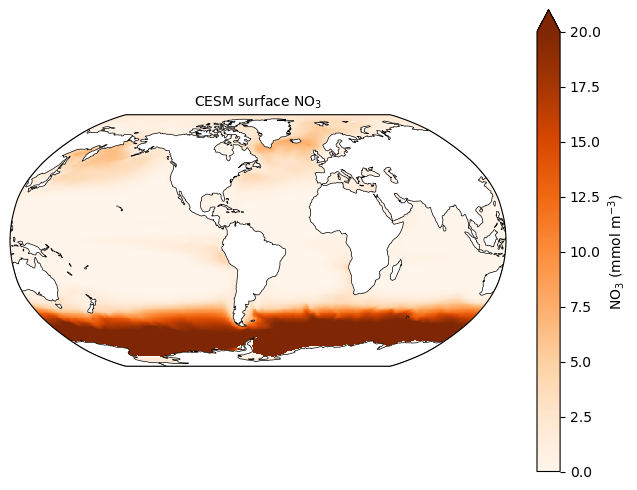

In [13]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax.set_title('CESM surface NO$_3$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats, ds_annual.NO3.sel(year=2010).isel(z_t=0))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

## Compare long-term mean to World Ocean Atlas 2018

- About the [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas)
- [Data access to WOA18](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/)

We've already regridded the WOA data to be on the same grid as the CESM data, so we don't need to worry about that step. However, if you wanted to compare to a dataset that's on a different grid, you'd need to go through the regridding process, which is beyond the scope of this cookbook.

This dataset has also already had a time mean taken, so there's no time coordinate.

*You might notice that three are three coordinates: `z_t`, `z_w`, and `z_w_bot`. Each of these are different versions of the same vertical coordinate - `z_t` represents the midpoint of a depth layer, `z_w` the top, and `z_w_bot` the bottom. We use `z_t` in this demonstration.*

In [14]:
file = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/obs/WOA2018_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t
ds_woa

<xarray.Dataset> Size: 214MB
Dimensions:      (z_t: 60, nlat: 384, nlon: 320, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float32 240B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 480B 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 480B 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/17)
    TEMP         (z_t, nlat, nlon) float32 29MB nan nan nan nan ... nan nan nan
    SALT         (z_t, nlat, nlon) float32 29MB nan nan nan nan ... nan nan nan
    NO3          (z_t, nlat, nlon) float32 29MB nan nan nan nan ... nan nan nan
    O2           (z_t, nlat, nlon) float32 29MB nan nan nan nan ... nan nan nan
    SiO3         (z_t, nlat, nlon) float32 29MB nan nan nan nan ... nan nan nan
    PO4          (z_t, nlat, nlon) float32 29MB nan nan nan nan ... nan nan nan
    ...           ...
    DXT          (nlat, nlon) float64 983kB 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 983kB 5.94e+06 5.94e+06 ... 5.046e+06
    TAREA        (nlat, nlon) float64 983kB 1.39e+13 1.39e+13 ... 7.432e+12
    KMT          (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    dz           (z_t) float64 480B 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
Attributes:
    history:  created by kristen krumhardt on 2019-10-25

In [15]:
ds_mean = ds_annual.mean("year")

In [16]:
NO3_diff = ds_mean.NO3 - ds_woa.NO3
PO4_diff = ds_mean.PO4 - ds_woa.PO4
SiO3_diff = ds_mean.SiO3 - ds_woa.SiO3

### Surface comparison
We choose to set up a dictionary with some parameters for each plot we want to make, to cut down on repetition in the actual plotting code block. This could be condensed even further, but there's a tradeoff between conciseness and readability! We specify the variables we want to plot (in this case different nutrients) and things like the colormaps and normalization. In addition to plotting each nutrient from the modeled data and observations, we also plot the bias, which is the difference between the two datasets. This helps us see how the model differs from observations.


In [17]:
ds_dict_surf = {'CESMNO3': {'title': 'CESM surface NO$_3$',
                       'label': 'NO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Greens',
                       'vmin': 0, 'vmax': 20,
                       'ds': ds_mean.NO3},
           'WOANO3':  {'title': 'WOA surface NO$_3$',
                       'label': 'NO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Greens',
                       'vmin': 0, 'vmax': 20,
                       'ds': ds_woa.NO3},
           'DIFFNO3': {'title': 'Surface NO$_3$ model bias',
                       'label': 'NO$_3$ bias (mmol m$^{-3}$)',
                       'cmap': 'bwr',
                       'vmin': -10, 'vmax': 10,
                       'ds': ds_mean.NO3 - ds_woa.NO3},
           'CESMPO4': {'title': 'CESM surface PO$_4$',
                       'label': 'PO$_4$ (mmol m$^{-3}$)',
                       'cmap': 'Oranges',
                       'vmin': 0, 'vmax': 2,
                       'ds': ds_mean.PO4},
           'WOAPO4':  {'title': 'WOA surface PO$_4$',
                       'label': 'PO$_4$ (mmol m$^{-3}$)',
                       'cmap': 'Oranges',
                       'vmin': 0, 'vmax': 2,
                       'ds': ds_woa.PO4},
           'DIFFPO4': {'title': 'Surface PO$_4$ model bias',
                       'label': 'PO$_4$ bias (mmol m$^{-3}$)',
                       'cmap': 'bwr',
                       'vmin': -1, 'vmax': 1,
                       'ds': ds_mean.PO4 - ds_woa.PO4},
           'CESMSiO3': {'title': 'CESM surface SiO$_3$',
                       'label': 'SiO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Blues',
                       'vmin': 0, 'vmax': 30,
                       'ds': ds_mean.SiO3},
           'WOASiO3':  {'title': 'WOA surface SiO$_3$',
                       'label': 'SiO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Blues',
                       'vmin': 0, 'vmax': 30,
                       'ds': ds_woa.SiO3},
           'DIFFSiO3': {'title': 'Surface SiO$_3$ model bias',
                       'label': 'SiO$_3$ bias (mmol m$^{-3}$)',
                       'cmap': 'bwr',
                       'vmin': -15, 'vmax': 15,
                       'ds': ds_mean.SiO3 - ds_woa.SiO3}
          }
                        

Here we pull from the above dictionary to actually make the plots.

In [ ]:
fig = plt.figure(figsize=(18,10))


plot_count = 1
for key, item in ds_dict_surf.items():
    ax = fig.add_subplot(3,3,plot_count, projection=ccrs.Robinson(central_longitude=305.0))
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    ax.set_title(item['title'], fontsize=10)
    lon, lat, field = adjust_pop_grid(lons, lats, item['ds'].isel(z_t=0))
    pc=ax.pcolormesh(lon, lat,field, vmin=item['vmin'], vmax=item['vmax'], cmap=item['cmap'],
                     transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,label=item['label'])

    plot_count += 1
    

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Comparison at 100m

Similar to above, but at a depth of 100m rather than at the surface.

In [ ]:
ds_dict_100m = {'CESMNO3': {'title': 'CESM 100m NO$_3$',
                       'label': 'NO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Greens',
                       'vmin': 0, 'vmax': 20,
                       'ds': ds_mean.NO3},
           'WOANO3':  {'title': 'WOA 100m NO$_3$',
                       'label': 'NO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Greens',
                       'vmin': 0, 'vmax': 20,
                       'ds': ds_woa.NO3},
           'DIFFNO3': {'title': '100m NO$_3$ model bias',
                       'label': 'NO$_3$ bias (mmol m$^{-3}$)',
                       'cmap': 'bwr',
                       'vmin': -10, 'vmax': 10,
                       'ds': ds_mean.NO3 - ds_woa.NO3},
           'CESMPO4': {'title': 'CESM 100m PO$_4$',
                       'label': 'PO$_4$ (mmol m$^{-3}$)',
                       'cmap': 'Oranges',
                       'vmin': 0, 'vmax': 2,
                       'ds': ds_mean.PO4},
           'WOAPO4':  {'title': 'WOA 100m PO$_4$',
                       'label': 'PO$_4$ (mmol m$^{-3}$)',
                       'cmap': 'Oranges',
                       'vmin': 0, 'vmax': 2,
                       'ds': ds_woa.PO4},
           'DIFFPO4': {'title': '100m PO$_4$ model bias',
                       'label': 'PO$_4$ bias (mmol m$^{-3}$)',
                       'cmap': 'bwr',
                       'vmin': -1, 'vmax': 1,
                       'ds': ds_mean.PO4 - ds_woa.PO4},
           'CESMSiO3': {'title': 'CESM 100m SiO$_3$',
                       'label': 'SiO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Blues',
                       'vmin': 0, 'vmax': 30,
                       'ds': ds_mean.SiO3},
           'WOASiO3':  {'title': 'WOA 100m SiO$_3$',
                       'label': 'SiO$_3$ (mmol m$^{-3}$)',
                       'cmap': 'Blues',
                       'vmin': 0, 'vmax': 30,
                       'ds': ds_woa.SiO3},
           'DIFFSiO3': {'title': '100m SiO$_3$ model bias',
                       'label': 'SiO$_3$ bias (mmol m$^{-3}$)',
                       'cmap': 'bwr',
                       'vmin': -15, 'vmax': 15,
                       'ds': ds_mean.SiO3 - ds_woa.SiO3}
          }
                        

In [ ]:
fig = plt.figure(figsize=(18,10))


plot_count = 1
for key, item in ds_dict_100m.items():
    ax = fig.add_subplot(3,3,plot_count, projection=ccrs.Robinson(central_longitude=305.0))
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    ax.set_title(item['title'], fontsize=10)
    lon, lat, field = adjust_pop_grid(lons, lats, item['ds'].isel(z_t=10))
    pc=ax.pcolormesh(lon, lat,field, vmin=item['vmin'], vmax=item['vmax'], cmap=item['cmap'],
                     transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,label=item['label'])

    plot_count += 1

## Global mean macronutrient profiles

 Let's write a function to take a global mean of the variables we're interested in, so that we can look at some depth profiles rather than maps. Also remember that we already took a mean over the whole time range (and the WOA dataset already had this mean taken), so this is a mean in time as well. Like the above maps, we also plot a bias panel to directly compare the difference between the datasets.

### <font color=#FF0000>Not currently being done correctly for CESM data!</font>

In [ ]:
def global_mean(ds, ds_grid, compute_vars, normalize=True, include_ms=False):
    """
    Compute the global mean on a POP dataset. 
    Return computed quantity in conventional units.
    """

    other_vars = list(set(ds.variables) - set(compute_vars))

    if include_ms: # marginal seas!
        surface_mask = ds_grid.TAREA.where(ds_grid.KMT > 0).fillna(0.)
    else:
        surface_mask = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.)        
    
    masked_area = {
        v: surface_mask.where(ds[v].notnull()).fillna(0.) 
        for v in compute_vars
    }
    
    with xr.set_options(keep_attrs=True):
        
        dso = xr.Dataset({
            v: (ds[v] * masked_area[v]).sum(['nlat', 'nlon'])
            for v in compute_vars
        })
        
        if normalize:
            dso = xr.Dataset({
                v: dso[v] / masked_area[v].sum(['nlat', 'nlon'])
                for v in compute_vars
            })            
                
    return dso

In [ ]:
ds_glb = global_mean(ds_mean, ds_grid, ['NO3','PO4','SiO3']).compute()

In [ ]:
ds_glb_woa = global_mean(ds_woa, ds_grid, ['NO3','PO4','SiO3']).compute()

Rather than setting up a dictionary of parameters, here we choose to make the plots inline since there aren't as many.

In [ ]:
fig = plt.figure(figsize=(6,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)

### Row 1  - NO3

ax = fig.add_subplot(3,2,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3, color='lightgreen')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# Bias plot

ax = fig.add_subplot(3,2,2)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

### Row 2  - PO4

ax = fig.add_subplot(3,2,3)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3, color='peachpuff')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3, color='orange')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# Bias plot

ax = fig.add_subplot(3,2,4)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

### Row 3  - SiO3

ax = fig.add_subplot(3,2,5)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3, color='lightblue')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3, color='blue')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# Bias plot

ax = fig.add_subplot(3,2,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()



And close the Dask cluster we spun up at the beginning.

In [ ]:
cluster.close()

---

## Summary
You've learned how to plot and evaluate the distribution of some key ocean nutrients in CESM output.

## Resources and references

- [Converting from monthly to annual data](https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/)
- [About World Ocean Atlas data](https://www.ncei.noaa.gov/products/world-ocean-atlas)
- [World Ocean Atlas data location](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/)
- A resource introducing the role of nutrients in the ocean?